# Dynamics of a mixture of mesogens and SW nanoparticles 
2021-08-01 Version 1.5

In [58]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import math

In [59]:
# Define parameters for the SW free energy, at selected values of lambda, 
# as given by Sastre et al. https://doi.org/10.1080/00268976.2017.1392051

# Matrix B collects constants for lambda >= 1.1, where
# A1 = b0 rho* + b1 rho*^2 + b2 rho*^3.
#    b0,     b1,       b2           lambda
B=np.array([[-0.74484,-0.382173,-1.63313],   # 1.1
   [-1.51817,-1.58568,-1.40168],    # 1.2
   [-2.40494,-3.04343,-1.16285],    # 1.3
   [-3.46854,-4.36238,1.46006],     # 1.4
   [-4.74229,-5.34853,3.10155],     # 1.5
   [-6.24987,-5.88535,4.48369],     # 1.6
   [-8.01193,-5.8906,5.34814],      # 1.7
   [-10.0523,-5.27555,5.38749]] )    # 1.8

In [60]:
# For lambda = 1.1, A2 = a0 rho* + a1 rho*^2 + a2 rho*^3
a0=-0.315714
a1=-0.405783
a2=0.4394

# Matrix A collects constants for cases lambda> 1.1, 
# when A2 = g2 rho* exp(-h2 rho*^2) + f2 tanh( c2 rho*)  
#  g2,        h2,     f2,        c2 
A=np.array( [[0,0,0,0],
   [-0.754123,1.54113,0,0],                # lambda = 1.20
   [-0.400299,4.81518,-0.221092,3.42486],  # lambda = 1.30
   [-0.311957,9.62637,-0.275382,4.80383],  # lambda = 1.40
   [-0.301985,12.7563,-0.305239,6.10676],  # lambda = 1.50
   [-0.242938,10.8684,-0.333435,7.67705],  # lambda = 1.60
   [-0.310091,16.5368,-0.376464,8.31355],  # lambda = 1.70
   [0.385677,1.98941,-0.539128,8.40071]])   # lambda = 1.80, WARNING g2 was (-) in Ref. 

## Free energy terms and derivatives for the SW fluid

### Hard sphere aHS

In [61]:
# We use as our scaled variable c, with  rho* = phi c.
# Parameter phi = phi=|r|*sigma**3/alpha. 
def aHS(c,phi):
    rho = phi*c
    eta = math.pi/6.0 * rho
    resultado= (4*eta - 3*eta**2)/(1-eta)**2
    return resultado

# derivative of aHS with respect to eta
def daHS(c,phi):
    rho = phi*c
    eta = math.pi/6.0 * rho
    resultado=(2*(-eta+ 2))/(1-eta)**3
    return resultado

### Free-energy perturbation term to the first order in beta 

In [62]:
# Free energy perturbation A1
def A1(c,phi,Lambda):
    rho = phi*c
    resultado=B[Lambda-1][0]*rho + B[Lambda-1][1]*rho**2 + B[Lambda-1][2]*rho**3
    return resultado

# Derivative of A1 with respect to rho*
def dA1(c,phi,Lambda):
    rho = phi*c
    resultado=B[Lambda-1][0]+2*B[Lambda-1][1]*rho + 3*B[Lambda-1][2]*rho**2
    return resultado

### Free-energy perturbation term to the second order in beta 

In [63]:
# Free energy perturbation A2 
def A2(c,phi,Lambda):
    rho = phi*c    
    if Lambda==1:
        resultado= a0*rho + a1*rho**2 + a2*rho**3
    else:
        resultado=A[Lambda-1][0]*rho*math.exp(-A[Lambda-1][1]*rho**2) + A[Lambda-1][2]*math.tanh(A[Lambda-1][3]*rho)
    return resultado

# Derivative of A2 with respect to rho*
def dA2(c,phi,Lambda):
    rho = phi*c
    if Lambda==1:
        resultado=a0 + 2*a1*rho + 3*a2*rho**2
    else:
        resultado=((A[Lambda-1][0])*math.exp(-(A[Lambda-1][1])*rho**2))*(1- 2*((A[Lambda-1][1])*rho**2) +
                     (A[Lambda-1][3])*(A[Lambda-1][2])*1/(math.cosh((A[Lambda-1][3])*rho))**2) 
    return resultado

### Total free energy a_SW = A_SW/(N k T) 

In [64]:
def aSW(c,phi,Lambda,T):
    resultado= aHS(c,phi) + (1/T)*A1(c,phi,Lambda) + (1/T)**2*A2(c,phi,Lambda)
    return resultado

## Reduced chemical potential for the SW

In [65]:
# Reduced chemical potential mu* = mu/mu_HS 
def mustar(c,phi,Lambda,T):
    rho = phi*c
    resultado= (3/(4*math.pi))*((aSW(c,phi,Lambda,T)/rho) + (math.pi/6)*daHS(c,phi) + (1/T)*dA1(c,phi,Lambda) + ((1/T)**2)*dA2(c,phi,Lambda))
    return resultado

## Auxiliar field inside the laplacian operator (in the dynamical equation for c)

In [66]:
# inlaplacian = c mu* + alpha' s^2, which is what is inside the Laplacian operator in the 
# dynamical equation for the conserved variable c
def inlaplacian(c,phi,Lambda,T,alphap,s,N):
# DEBUG
#     print("inlaplacian::")
#     print("inlaplacian::input: <c>=",             c.mean(), "+/-",           c.std())
    
    mu_estrella= np.full((N,N), 0.000)  # CAREFUL mu_estrella = c is an alias, not a copy, of the object "c"
    
    for i in np.arange(N):
        for j in np.arange(N):
            mu_estrella[i][j] = mustar(c[i][j],phi,Lambda,T)
            
    resultado= c* mu_estrella + alphap * (s**2)  

# DEBUG
#     print("inlaplacian::out: <c>=", c.mean(), "+/-", c.std())
#     print("inlaplacian::out: <mu*>=", mu_estrella.mean(), "+/-", mu_estrella.std())
#     print("inlaplacian::out: <res>=",   resultado.mean(), "+/-",   resultado.std())
    
    return resultado

## Finite difference operations

In [67]:
# Laplacian operator in 2D using finite differences.
def laplacian2D(Z,dx):

    center  = Z[1:-1, 1:-1]
    
    #w toma desde la primer fila hasta la antepenúltima [] y desde segunda columna hasta la penúltima []
    w   = Z[0:-2, 1:-1]
    
    #e toma desde tercer fila hasta la última [] y desde segunda columna hasta la penúltima []
    e   = Z[2:  , 1:-1]   
    
    #n toma desde la  fila 1 hasta la penúltima [] y desde la columna 2 hasta la última []
    n   = Z[1:-1, 2:  ]
    
    #s toma desde la  fila 1 hasta la penúltima [] y desde la primera hasta la antepenúltima []
    s   = Z[1:-1, 0:-2]
    
    #ne toma desde la  fila 2 hasta la última [] y desde la tercera hasta la última []
    ne  = Z[2:  , 2:  ]
    
    #ne toma desde la  primera hasta la antepenúltima [] y desde la tercera hasta la última []
    nw  = Z[0:-2, 2:  ]
    
    #se toma desde la  tercera hasta la última [] y desde la primera hasta la antepenúltima []
    se  = Z[2:, 0:-2]
    
    #sw toma desde la  primera hasta la antepenúltima [] y desde la primera hasta la antepenúltima []
    sw  = Z[0:-2, 0:-2]
    
    # Weights for the different contributions
    dif2 = (w+e+n+s)/6.0 + (ne+nw+se+sw)/12.0 
    dif2 = dif2 - center
    
    # Scale by grid size squared and return.
    dif2 = dif2/dx**2 
       
    return dif2

In [68]:
# Apply periodic boundary conditions             
def PBC(Z):
    # Fill two buffer columns     
    Z[ 0,:] = Z[-2,:]    # Fill column  0 from column -2          
    Z[-1,:] = Z[ 1,:]    # Fill column -1 from column  1          
    
    # Fill two buffer rows
    Z[:, 0] = Z[:,-2]   # fill row  0 from row -2   
    Z[:,-1] = Z[:, 1]   # fill row -1 from row  1
   
    # Fill four buffer corners
    Z[0,0]   = Z[-2,-2]
    Z[0,-1]  = Z[-2, 1]
    Z[-1,0]  = Z[ 1,-2]
    Z[-1,-1] = Z[ 1, 1]

    
    return Z

In [69]:
# Apply plane-wave perturbations to a given field
def perturba(field, k, A):      # field is an array, k a wavenumber, A the perturbation amplitude
    for x in range(len(field)):
        for y in range(len(field)):
            field[x, y] += A*np.sin(k*float(y))     
            field[x, y] += A*np.sin(k*float(x))
    return field

In [70]:
# Advance the fields using the dynamics for one time step
def solve_dynamics(c,phi,Lambda,T,alphap,s,N,dx,dt,time_step,R,r):
    
    mu_mean, sigma_stdev = 0, 0.0001 # mean and standard deviation
    thermal_s = np.random.normal(mu_mean, sigma_stdev, (L,L))
    thermal_c = np.random.normal(mu_mean, sigma_stdev, (L,L))
    
    
    # DEBUG:
    #print("solve_dynamics::time_step=",time_step)
    # print("solve_dynamics::input: <c>=", c.mean(), "+/-", c.std())                 
    #
    # For dilute HS:
    # auxHS = c + alphap * s**2 
    
    # For SW:
    auxSW = inlaplacian(c,phi,Lambda,T,alphap,s,N)
        
    #nabla2_aux almacena laplaciano de aux
    nabla2_aux = laplacian2D(auxSW,dx)
    nabla2_s   = laplacian2D(s, dx)
        
    #parámetro de orden y concentracion en el centro
    sc = s[1:-1,1:-1]
    cc = c[1:-1,1:-1]
        
    #Ecuaciones no lineales, se hace un incremento en el tiempo
    s[1:-1,1:-1] = sc + dt * (nabla2_s - r * sc - sc**3 - sc * cc)  + thermal_s
    c[1:-1,1:-1] = cc + dt * R * nabla2_aux + thermal_c

    #se aplican condiciones periodicas en la frontera tanto en s como en c
    for x in (s, c):
        PBC(x)
    
    # DEBUG
#     print("solve_dynamics::<auxSW>=", auxSW.mean(), "+/-", auxSW.std())         
#     print("solve_dynamics::<auxHS>=", auxHS.mean(), "+/-", auxHS.std())
#     print("solve_dynamics::<nabla2_aux>=", nabla2_aux.mean(), "+/-", nabla2_aux.std())  
#     print("solve_dynamics::out: <c>=", c.mean(), "+/-", c.std())                 


## Output functions

In [71]:
# Save s and c fields to files 
def save_fields(s, c, step, nb):
    LC_file = "matrix" + "_s_" + str(step) + "_nb_" + str(nb) + ".txt"
    np.savetxt(LC_file, s, delimiter="\t")
    
    NPs_file = "matrix" + "_c_" + str(step) + "_nb_" + str(nb) + ".txt"
    np.savetxt(NPs_file, c, delimiter="\t")

In [72]:
# Plot the 2D arrays, using grayscale for c and "seismic" colormap for s
def plot_fields_in_2D(s,c):
    
    plt.figure(figsize=(10, 3.5))

    plt.subplot(1, 2, 1)
    plt.imshow(c[1:-1,1:-1], cmap=plt.cm.gray)
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(s[1:-1,1:-1], cmap=plt.cm.seismic)
    plt.colorbar()
    
    
    plt.show()

In [73]:
# Plot 1D profiles of c and s, using black for c and red for s
def plot_fields_in_1D(s,c):
    plt.figure(figsize=(10, 3.5))

    plt.subplot(1, 2, 1)
    plt.plot(c[1:-1,1:-1], "k")  # k means blacK


    plt.subplot(1, 2, 2)
    plt.plot(s[1:-1,1:-1], "r")  # r means Red
    
   
    plt.show()

# From isotropic to nematic

## Initialize the program

In [74]:
# Square-Well parameters
Lambda=1      # integer selector: lambda_SW = 1 + Lambda/10 (for instance, Lambda = 1 -> lambda_SW = 1.1)
T= 0.90        # reduced temperatura T* = (k T)/epsilon 

# Initial conditions
n_wavelengths = 2 # n_wavelengths es el número de longitudes de onda que caben en la caja, use only powers of two

c0= 0.050
s0= 0.001
Ampl = 0.001 # Ampl es la amplitud de la perturbación


# Time steps
nTimeSteps   =  4000  # total number of time steps to run 
print_period =  100  # number of time steps between program printouts


# Parameters for the scaled dynamical equations 
r = -1.0      # temperature control parameter sign, sgn(r) = sgn(T-Tc)
R = 2.0      # Reduced diffusivity, R
alphap=0.05  # Reduced coupling parameter, alpha' 
phi=1         # scaling factor, rho* = phi c

# Finite differences grid parameters
L = 64    # Physical spatial size 
N = L+2   # Augmented grid size with two extra points for PBC buffers
nb = 1    # numero de bloques (quizás nb por notebook), el número de veces que se repite una iteración
dx = 1.0      # pixel size
dt = 0.01     # time step

T_total = nTimeSteps*dt  # Total simulation time

c.mean = 0.0500 s.mean = 0.0010
c.min  = 0.0480  s.min = -0.0010
c.max  = 0.0520  s.max = 0.0030


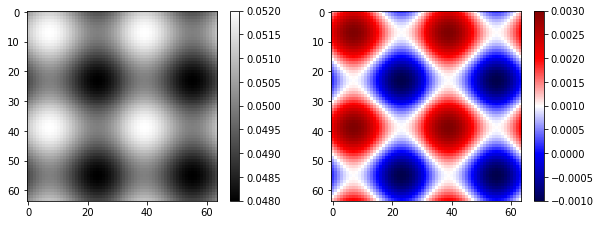

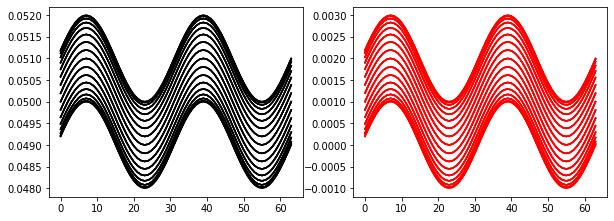

In [75]:
# Initial conditions for c and s start as homogenoeus fields
for block in range(1, nb+1):
    #Se define la matriz c y s y se llenan con las condiciones iniciales
    c = np.full((N,N), c0)
    s = np.full((N,N), s0) # elige este si vas de transición isótropo a nemático

# Calculate the wavelength and the wavenumber from size L and number of wavelengths in it
lambd = L//n_wavelengths    #  CAREFUL: // is the integer division operator
k = 2*np.pi/lambd # k=2pi/lambda is the wavenumber

# Apply plane-wave perturbations to s and c
for field in (s,c):
    perturba(field, k, Ampl)
    
# Print out statistics and plots of c and s to diagnose initial conditions
print("c.mean = {:.4f} s.mean = {:.4f}" .format(c.mean(), s.mean()))
print("c.min  = {:.4f}  s.min = {:.4f}" .format(c.min(), s.min()))
print("c.max  = {:.4f}  s.max = {:.4f}" .format(c.max(), s.max()))

# Plot s and c in 2D and 1D to diagnose initial conditions
plot_fields_in_2D(s, c)
plot_fields_in_1D(s, c)

# Save initial conditions to files
#save_fields(s, c, 0, block)

# Export figures of initial conditions

#dir = os.chdir('/home/erick/Desktop/pruebas/campo_C')
#plt.imshow(c, cmap=plt.cm.gray)
#plt.colorbar()
#plt.savefig('imagen0.png')
#plt.show()

#dir = os.chdir('/home/erick/Desktop/pruebas/Campo_S')
#plt.imshow(s, cmap=plt.cm.seismic)
#plt.colorbar()
#plt.savefig('imagen0.png')


## Solve the dynamics

Program will run nTimeSteps:  4000
Print results each print_period steps:  100
Total simulation time at the end: 40.0
Temperature: = 0.900
SW range lambda  = 1.100
wavenumber k = 0.196
wavelength = 32.000
 
time_step= 100
Tiempo CPU en segundos: 6.03
c.mean = 0.0500 s.mean = 0.0026
c.min  = 0.0463  s.min = -0.0044
c.max  = 0.0537  s.max = 0.0106


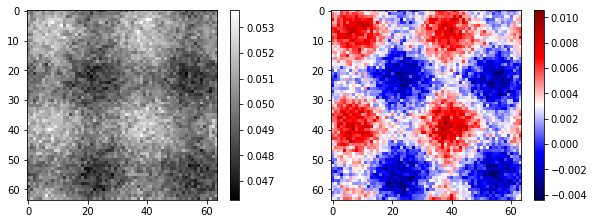

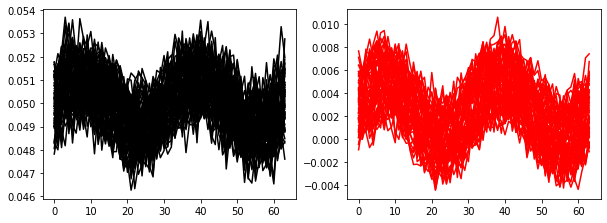

max_region_c: 0.053572061555988634 , max_region_s: 0.010616150802247563
min_region_c: 0.04626371469347049 , min_region_s: -0.004405350734254326
amplitude_c: 0.0036541734312590737 , amplitude_s: 0.007510750768250945
 
time_step= 200
Tiempo CPU en segundos: 12.82
c.mean = 0.0500 s.mean = 0.0067
c.min  = 0.0460  s.min = -0.0095
c.max  = 0.0541  s.max = 0.0237


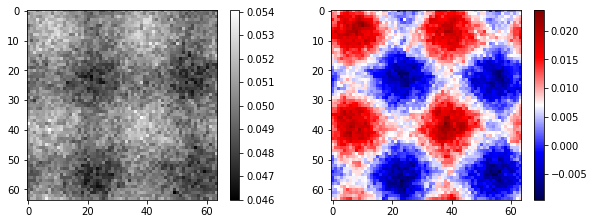

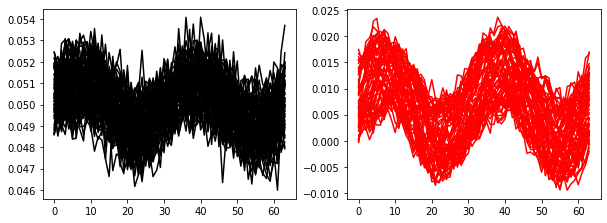

max_region_c: 0.05408476920005791 , max_region_s: 0.02369175239205382
min_region_c: 0.04616819978030633 , min_region_s: -0.008576305445073944
amplitude_c: 0.003958284709875793 , amplitude_s: 0.016134028918563883
 
time_step= 300
Tiempo CPU en segundos: 19.32
c.mean = 0.0501 s.mean = 0.0173
c.min  = 0.0454  s.min = -0.0212
c.max  = 0.0541  s.max = 0.0562


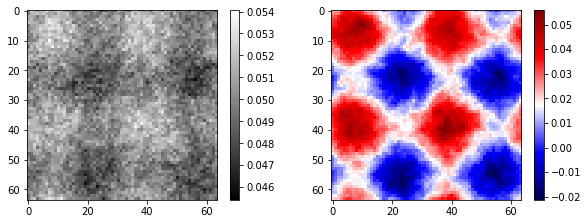

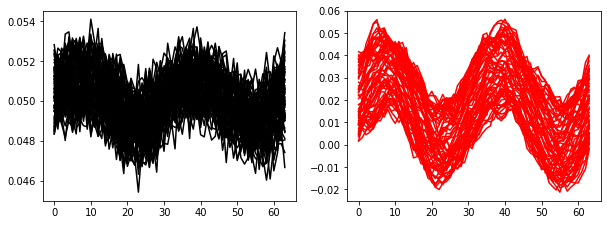

max_region_c: 0.053706406205280784 , max_region_s: 0.05616581078762342
min_region_c: 0.04543085517006992 , min_region_s: -0.020055915311516445
amplitude_c: 0.0041377755176054305 , amplitude_s: 0.03811086304956993
 
time_step= 400
Tiempo CPU en segundos: 26.07
c.mean = 0.0501 s.mean = 0.0444
c.min  = 0.0458  s.min = -0.0491
c.max  = 0.0542  s.max = 0.1379


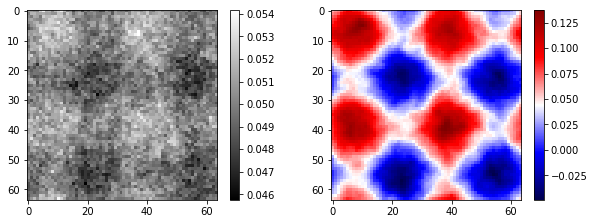

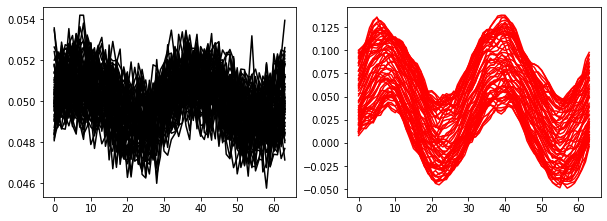

max_region_c: 0.05346364702057421 , max_region_s: 0.13792607195904122
min_region_c: 0.04599879161790365 , min_region_s: -0.04542081971388996
amplitude_c: 0.0037324277013352815 , amplitude_s: 0.09167344583646558
 
time_step= 500
Tiempo CPU en segundos: 32.59
c.mean = 0.0500 s.mean = 0.1119
c.min  = 0.0457  s.min = -0.1155
c.max  = 0.0542  s.max = 0.3301


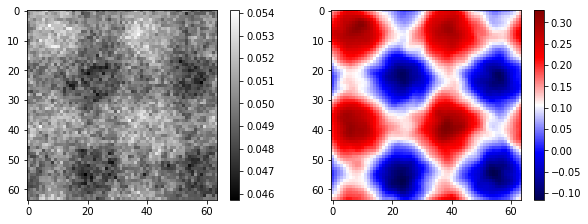

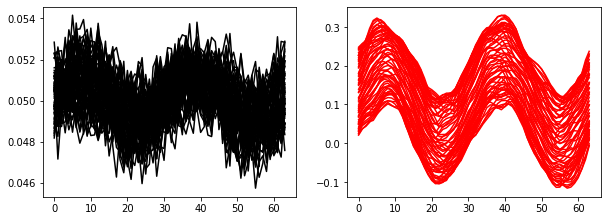

max_region_c: 0.053817645544175556 , max_region_s: 0.33006061452976027
min_region_c: 0.045957898631228844 , min_region_s: -0.10439328553569296
amplitude_c: 0.003929873456473356 , amplitude_s: 0.21722695003272663
 
time_step= 600
Tiempo CPU en segundos: 39.52
c.mean = 0.0501 s.mean = 0.2588
c.min  = 0.0451  s.min = -0.2752
c.max  = 0.0540  s.max = 0.6577


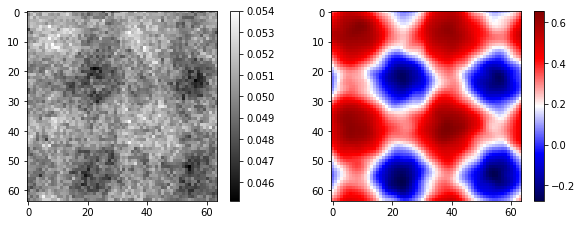

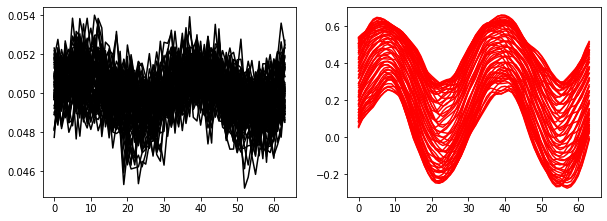

max_region_c: 0.05392643839791437 , max_region_s: 0.6576823726956124
min_region_c: 0.04531935135531675 , min_region_s: -0.24906041994183967
amplitude_c: 0.00430354352129881 , amplitude_s: 0.453371396318726
 
time_step= 700
Tiempo CPU en segundos: 46.63
c.mean = 0.0501 s.mean = 0.4640
c.min  = 0.0450  s.min = -0.5749
c.max  = 0.0544  s.max = 0.8966


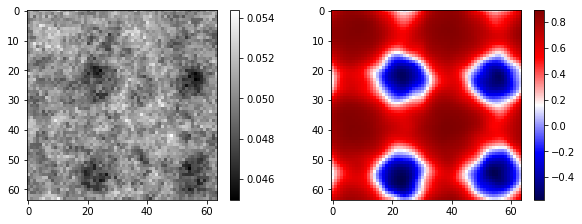

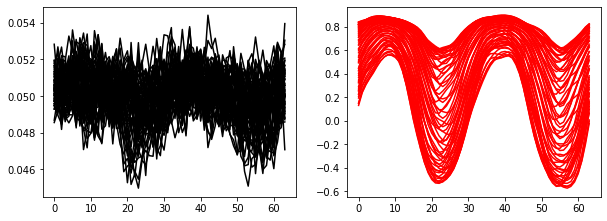

max_region_c: 0.05439988410419253 , max_region_s: 0.8965959705710802
min_region_c: 0.04498246321159496 , min_region_s: -0.5339166773321536
amplitude_c: 0.0047087104462987875 , amplitude_s: 0.715256323951617
 
time_step= 800
Tiempo CPU en segundos: 53.53
c.mean = 0.0501 s.mean = 0.6052
c.min  = 0.0423  s.min = -0.8546
c.max  = 0.0573  s.max = 0.9618


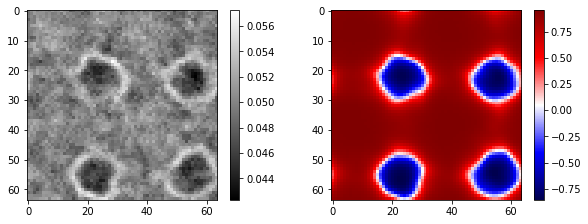

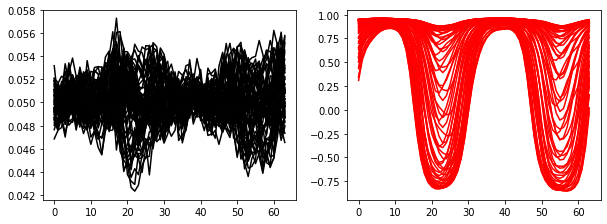

max_region_c: 0.05730735810553894 , max_region_s: 0.9617569760279315
min_region_c: 0.042307889550242485 , min_region_s: -0.8317138188028538
amplitude_c: 0.007499734277648228 , amplitude_s: 0.8967353974153927
 
time_step= 900
Tiempo CPU en segundos: 59.69
c.mean = 0.0501 s.mean = 0.6582
c.min  = 0.0401  s.min = -0.9534
c.max  = 0.0701  s.max = 0.9733


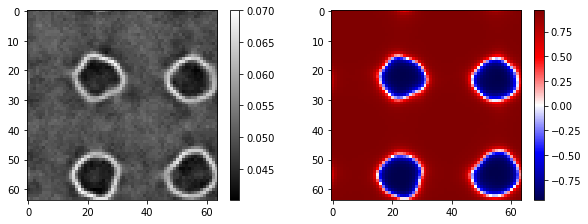

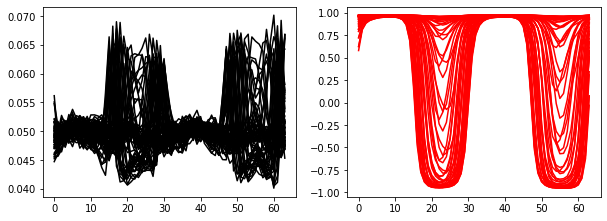

max_region_c: 0.068999859616121 , max_region_s: 0.9733236889933994
min_region_c: 0.04063219248589245 , min_region_s: -0.9483344811920733
amplitude_c: 0.014183833565114275 , amplitude_s: 0.9608290850927363
 
time_step= 1000
Tiempo CPU en segundos: 66.05
c.mean = 0.0500 s.mean = 0.6748
c.min  = 0.0344  s.min = -0.9746
c.max  = 0.0877  s.max = 0.9759


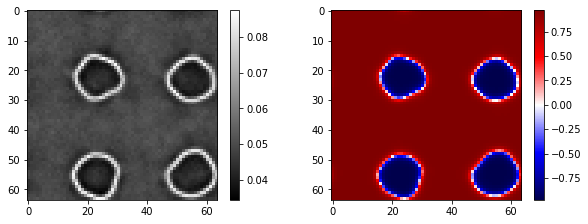

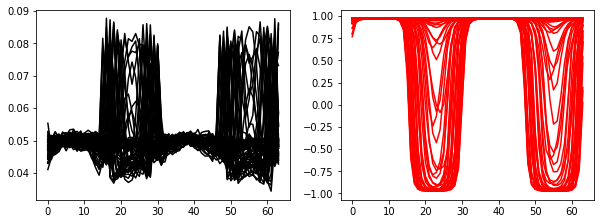

max_region_c: 0.08773368778840243 , max_region_s: 0.9759000853784956
min_region_c: 0.036872254617752925 , min_region_s: -0.9734657597325819
amplitude_c: 0.025430716585324753 , amplitude_s: 0.9746829225555387
 
time_step= 1100
Tiempo CPU en segundos: 72.22
c.mean = 0.0500 s.mean = 0.6812
c.min  = 0.0311  s.min = -0.9788
c.max  = 0.1042  s.max = 0.9769


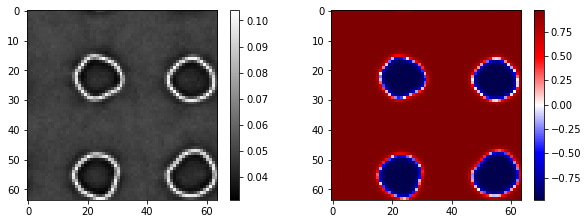

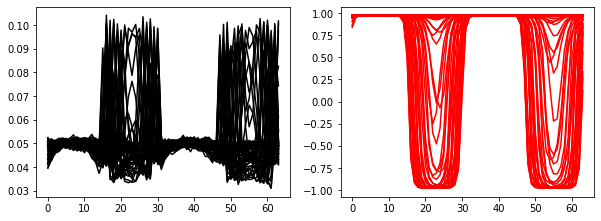

max_region_c: 0.10421022542810342 , max_region_s: 0.9765709515731316
min_region_c: 0.03340027226528895 , min_region_s: -0.9787782047002387
amplitude_c: 0.03540497658140723 , amplitude_s: 0.9776745781366851
 
time_step= 1200
Tiempo CPU en segundos: 78.73
c.mean = 0.0499 s.mean = 0.6850
c.min  = 0.0301  s.min = -0.9797
c.max  = 0.1138  s.max = 0.9781


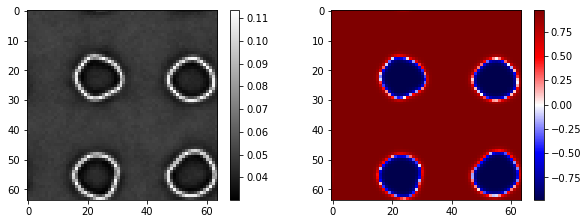

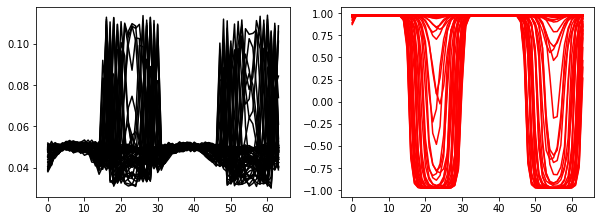

max_region_c: 0.1135584047065722 , max_region_s: 0.9773698222083806
min_region_c: 0.030925355456992962 , min_region_s: -0.979365029372082
amplitude_c: 0.04131652462478962 , amplitude_s: 0.9783674257902313
 
time_step= 1300
Tiempo CPU en segundos: 84.81
c.mean = 0.0499 s.mean = 0.6881
c.min  = 0.0286  s.min = -0.9802
c.max  = 0.1196  s.max = 0.9782


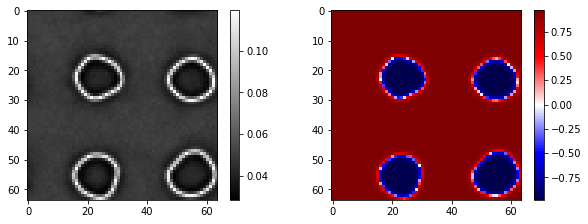

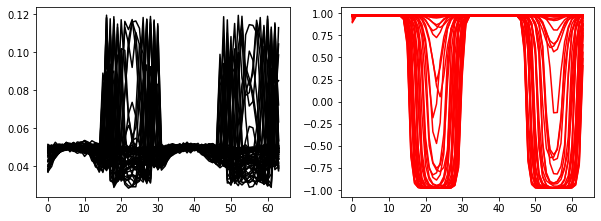

max_region_c: 0.11963758725590445 , max_region_s: 0.97816122669819
min_region_c: 0.028596339684371704 , min_region_s: -0.9802306109508525
amplitude_c: 0.04552062378576638 , amplitude_s: 0.9791959188245212
 
time_step= 1400
Tiempo CPU en segundos: 91.19
c.mean = 0.0499 s.mean = 0.6908
c.min  = 0.0281  s.min = -0.9811
c.max  = 0.1239  s.max = 0.9783


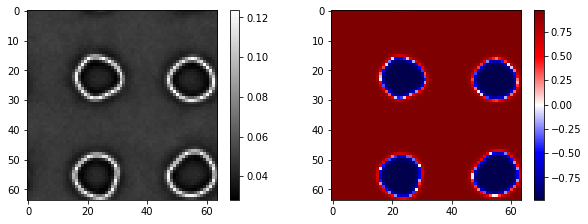

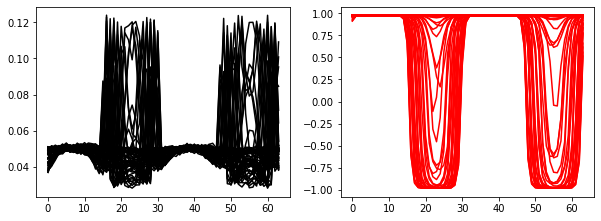

max_region_c: 0.12392079946028302 , max_region_s: 0.9782605123854612
min_region_c: 0.028161843863183156 , min_region_s: -0.9808192565963268
amplitude_c: 0.04787947779854993 , amplitude_s: 0.979539884490894
 
time_step= 1500
Tiempo CPU en segundos: 97.27
c.mean = 0.0499 s.mean = 0.6933
c.min  = 0.0272  s.min = -0.9816
c.max  = 0.1267  s.max = 0.9792


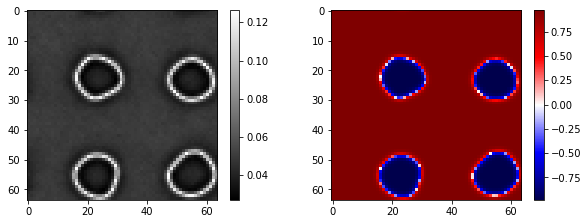

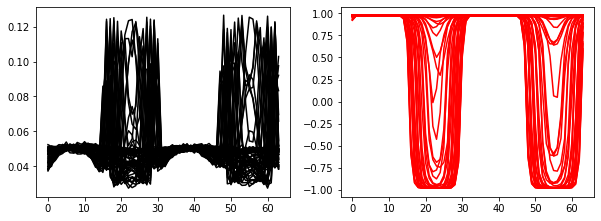

max_region_c: 0.12548299665183538 , max_region_s: 0.978385004753082
min_region_c: 0.027196459835465658 , min_region_s: -0.9816108232220219
amplitude_c: 0.04914326840818486 , amplitude_s: 0.9799979139875519
 
time_step= 1600
Tiempo CPU en segundos: 103.38
c.mean = 0.0499 s.mean = 0.6956
c.min  = 0.0263  s.min = -0.9831
c.max  = 0.1283  s.max = 0.9790


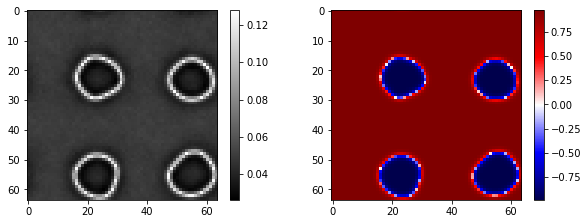

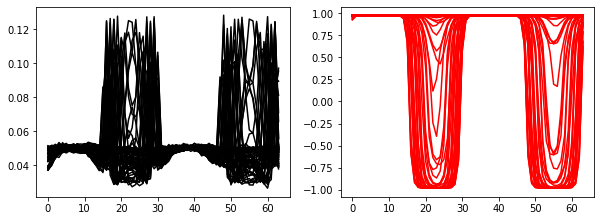

max_region_c: 0.1277134322754051 , max_region_s: 0.9786840631353083
min_region_c: 0.027170260839361113 , min_region_s: -0.9830784990897479
amplitude_c: 0.050271585718022 , amplitude_s: 0.980881281112528
 
time_step= 1700
Tiempo CPU en segundos: 109.38
c.mean = 0.0499 s.mean = 0.6977
c.min  = 0.0268  s.min = -0.9822
c.max  = 0.1296  s.max = 0.9791


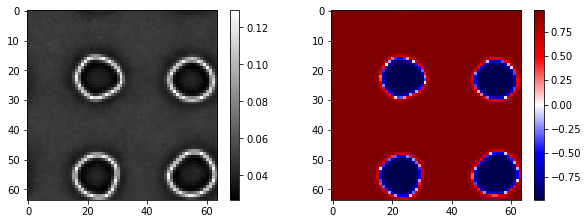

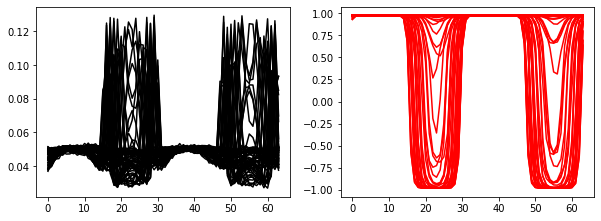

max_region_c: 0.12961907283146373 , max_region_s: 0.9788273776609095
min_region_c: 0.02728286118318343 , min_region_s: -0.9822013457252576
amplitude_c: 0.05116810582414015 , amplitude_s: 0.9805143616930836
 
time_step= 1800
Tiempo CPU en segundos: 115.90
c.mean = 0.0499 s.mean = 0.6998
c.min  = 0.0264  s.min = -0.9830
c.max  = 0.1312  s.max = 0.9793


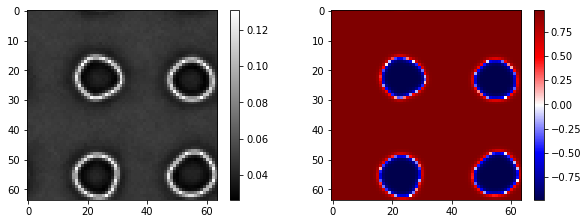

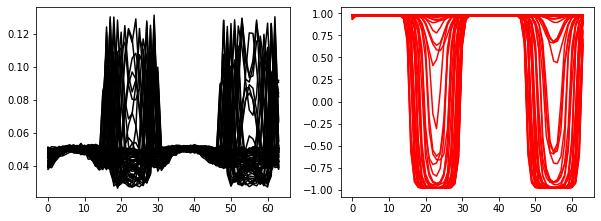

max_region_c: 0.13121575515645642 , max_region_s: 0.9789118750742919
min_region_c: 0.026366484452754357 , min_region_s: -0.9828717863375689
amplitude_c: 0.05242463535185103 , amplitude_s: 0.9808918307059304
 
time_step= 1900
Tiempo CPU en segundos: 121.87
c.mean = 0.0499 s.mean = 0.7016
c.min  = 0.0261  s.min = -0.9831
c.max  = 0.1327  s.max = 0.9795


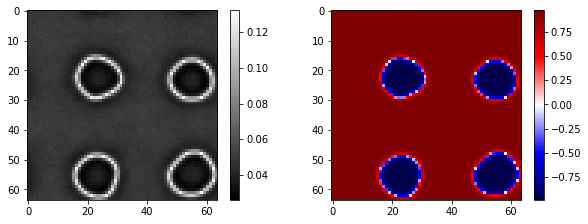

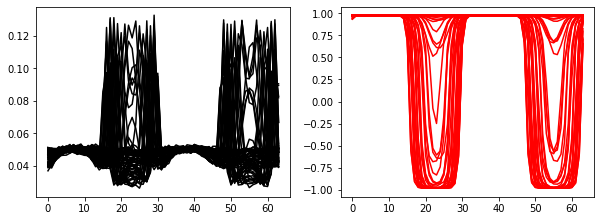

max_region_c: 0.13267886730017794 , max_region_s: 0.9789717057378295
min_region_c: 0.026088815511277594 , min_region_s: -0.9830673749437294
amplitude_c: 0.053295025894450176 , amplitude_s: 0.9810195403407795
 
time_step= 2000
Tiempo CPU en segundos: 128.34
c.mean = 0.0499 s.mean = 0.7034
c.min  = 0.0267  s.min = -0.9835
c.max  = 0.1326  s.max = 0.9793


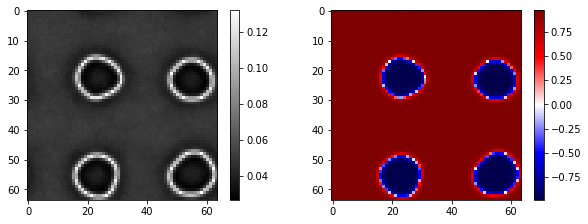

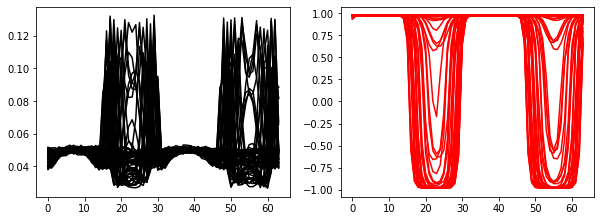

max_region_c: 0.1326121703513288 , max_region_s: 0.9791268781840965
min_region_c: 0.026902096902479244 , min_region_s: -0.9833851907318719
amplitude_c: 0.05285503672442478 , amplitude_s: 0.9812560344579841
 
time_step= 2100
Tiempo CPU en segundos: 134.78
c.mean = 0.0498 s.mean = 0.7051
c.min  = 0.0261  s.min = -0.9837
c.max  = 0.1326  s.max = 0.9794


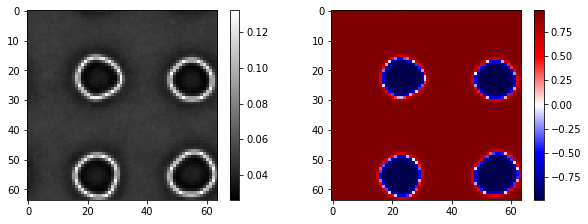

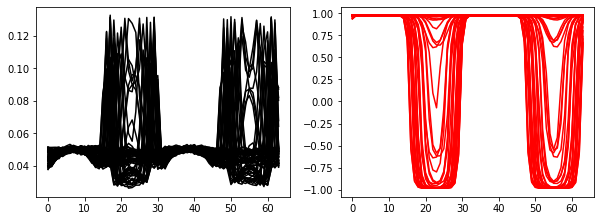

max_region_c: 0.13260944784890216 , max_region_s: 0.9794265695557398
min_region_c: 0.02609555524031507 , min_region_s: -0.9834298338817855
amplitude_c: 0.05325694630429355 , amplitude_s: 0.9814282017187627
 
time_step= 2200
Tiempo CPU en segundos: 141.51
c.mean = 0.0498 s.mean = 0.7068
c.min  = 0.0262  s.min = -0.9835
c.max  = 0.1335  s.max = 0.9792


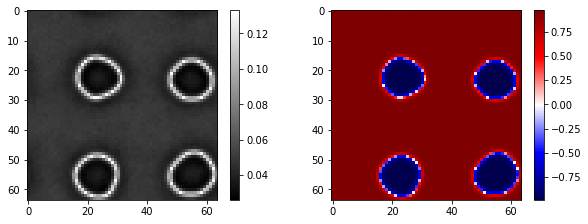

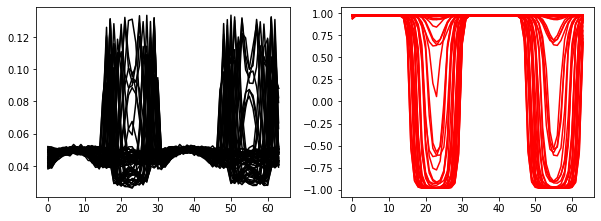

max_region_c: 0.1333665868647789 , max_region_s: 0.9791039007222583
min_region_c: 0.026181653253499262 , min_region_s: -0.9835289650918578
amplitude_c: 0.05359246680563982 , amplitude_s: 0.9813164329070581
 
time_step= 2300
Tiempo CPU en segundos: 147.95
c.mean = 0.0498 s.mean = 0.7084
c.min  = 0.0261  s.min = -0.9838
c.max  = 0.1343  s.max = 0.9798


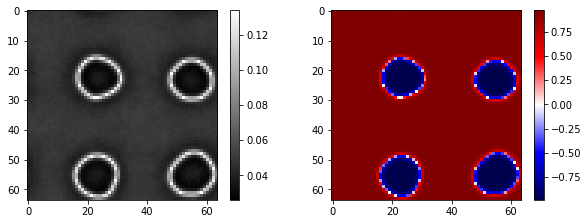

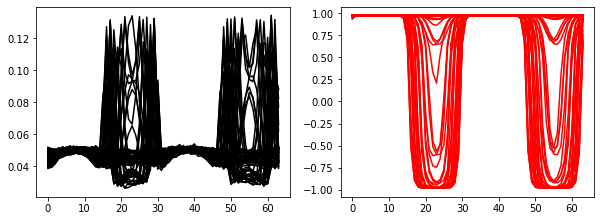

max_region_c: 0.1339027452150245 , max_region_s: 0.9797666413201082
min_region_c: 0.026101762300644857 , min_region_s: -0.9838444926471738
amplitude_c: 0.053900491457189816 , amplitude_s: 0.981805566983641
 
time_step= 2400
Tiempo CPU en segundos: 154.65
c.mean = 0.0498 s.mean = 0.7101
c.min  = 0.0267  s.min = -0.9844
c.max  = 0.1338  s.max = 0.9796


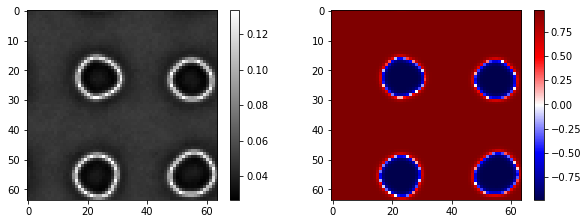

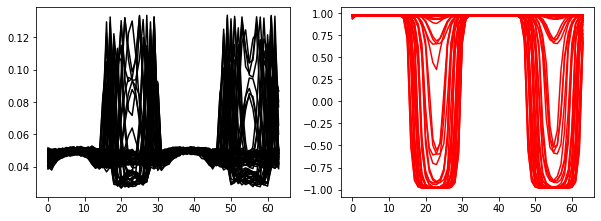

max_region_c: 0.1336896299182576 , max_region_s: 0.9791827059233509
min_region_c: 0.026687213133425886 , min_region_s: -0.9843703524140098
amplitude_c: 0.053501208392415865 , amplitude_s: 0.9817765291686804
 
time_step= 2500
Tiempo CPU en segundos: 160.86
c.mean = 0.0498 s.mean = 0.7118
c.min  = 0.0266  s.min = -0.9842
c.max  = 0.1350  s.max = 0.9797


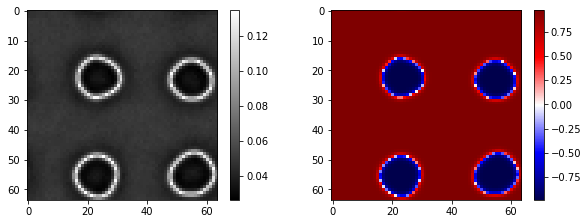

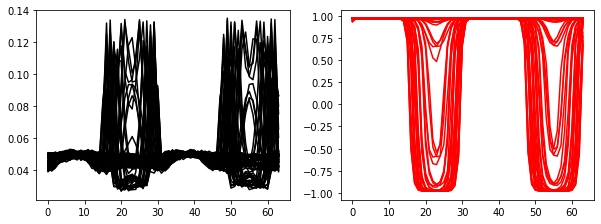

max_region_c: 0.13418277824861455 , max_region_s: 0.979728931201896
min_region_c: 0.02659050093735899 , min_region_s: -0.9841548780633411
amplitude_c: 0.05379613865562778 , amplitude_s: 0.9819419046326185
 
time_step= 2600
Tiempo CPU en segundos: 166.95
c.mean = 0.0498 s.mean = 0.7135
c.min  = 0.0261  s.min = -0.9848
c.max  = 0.1351  s.max = 0.9796


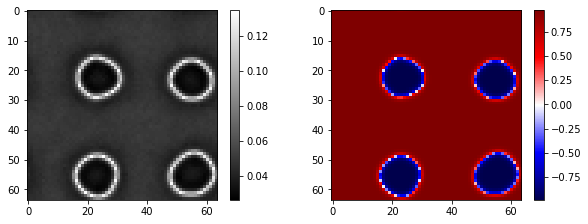

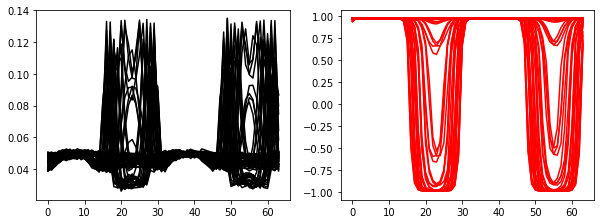

max_region_c: 0.13427442223272829 , max_region_s: 0.9796383270649464
min_region_c: 0.026103826668032327 , min_region_s: -0.9841791469726255
amplitude_c: 0.05408529778234798 , amplitude_s: 0.981908737018786
 
time_step= 2700
Tiempo CPU en segundos: 174.00
c.mean = 0.0498 s.mean = 0.7151
c.min  = 0.0265  s.min = -0.9852
c.max  = 0.1349  s.max = 0.9797


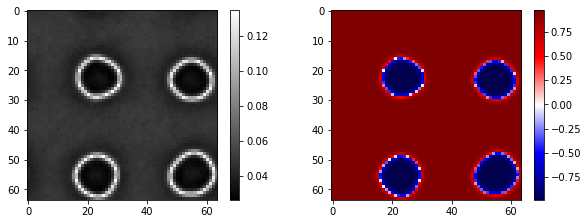

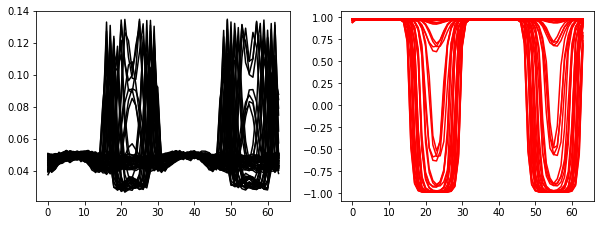

max_region_c: 0.1348398331375805 , max_region_s: 0.9794707516370238
min_region_c: 0.026454162057669973 , min_region_s: -0.9852191389782091
amplitude_c: 0.05419283553995526 , amplitude_s: 0.9823449453076165
 
time_step= 2800
Tiempo CPU en segundos: 180.94
c.mean = 0.0498 s.mean = 0.7167
c.min  = 0.0270  s.min = -0.9849
c.max  = 0.1354  s.max = 0.9799


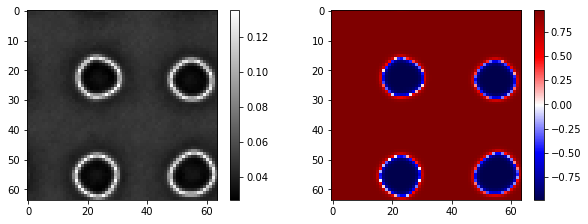

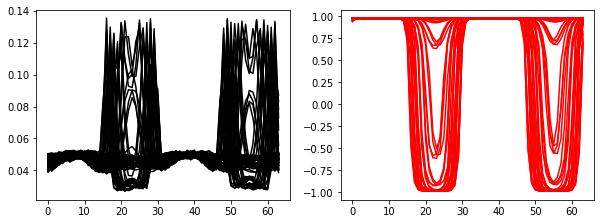

max_region_c: 0.13536497048339924 , max_region_s: 0.9794468273546146
min_region_c: 0.026952183915423738 , min_region_s: -0.9848991235731016
amplitude_c: 0.05420639328398775 , amplitude_s: 0.9821729754638582
 
time_step= 2900
Tiempo CPU en segundos: 187.67
c.mean = 0.0498 s.mean = 0.7182
c.min  = 0.0265  s.min = -0.9853
c.max  = 0.1365  s.max = 0.9796


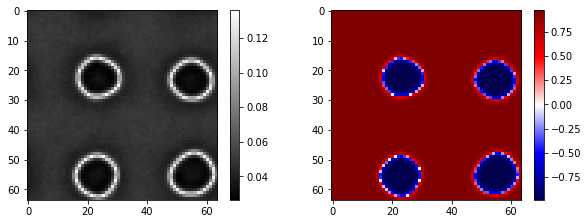

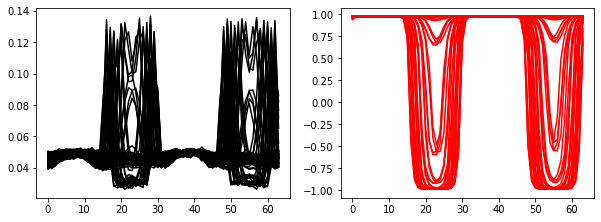

max_region_c: 0.13649330596603992 , max_region_s: 0.9793224929458824
min_region_c: 0.026522234354503686 , min_region_s: -0.9852932031844736
amplitude_c: 0.05498553580576812 , amplitude_s: 0.9823078480651779
 
time_step= 3000
Tiempo CPU en segundos: 195.10
c.mean = 0.0498 s.mean = 0.7197
c.min  = 0.0266  s.min = -0.9854
c.max  = 0.1358  s.max = 0.9794


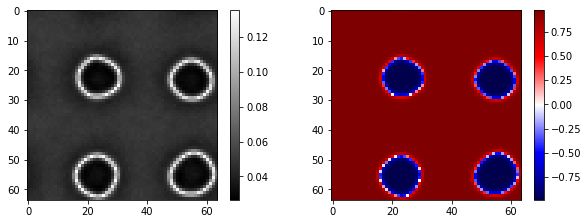

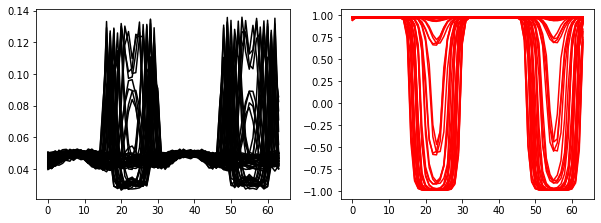

max_region_c: 0.13459517415362665 , max_region_s: 0.9793440044746492
min_region_c: 0.02659174068142021 , min_region_s: -0.9854052931830934
amplitude_c: 0.05400171673610322 , amplitude_s: 0.9823746488288714
 
time_step= 3100
Tiempo CPU en segundos: 201.73
c.mean = 0.0498 s.mean = 0.7213
c.min  = 0.0264  s.min = -0.9858
c.max  = 0.1362  s.max = 0.9796


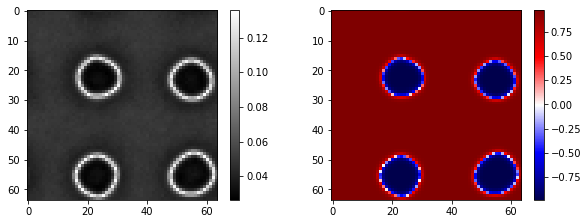

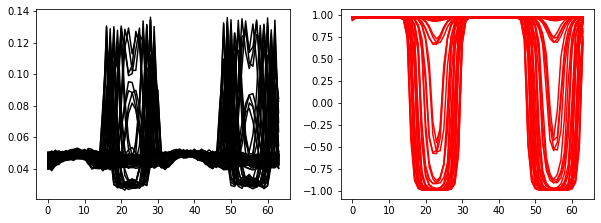

max_region_c: 0.13618112782588335 , max_region_s: 0.9791990554854004
min_region_c: 0.026353294406572764 , min_region_s: -0.9857522487549955
amplitude_c: 0.05491391670965529 , amplitude_s: 0.9824756521201979
 
time_step= 3200
Tiempo CPU en segundos: 208.53
c.mean = 0.0498 s.mean = 0.7228
c.min  = 0.0260  s.min = -0.9857
c.max  = 0.1361  s.max = 0.9795


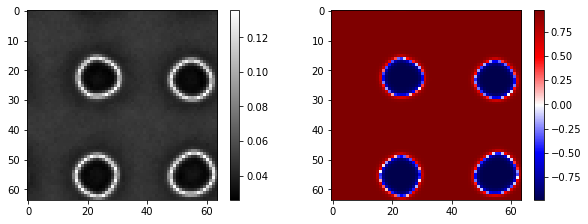

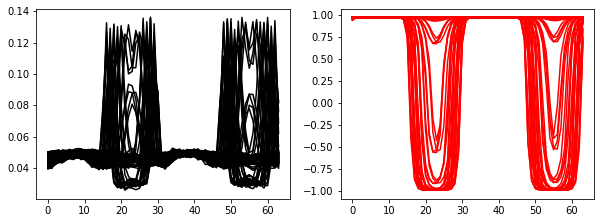

max_region_c: 0.1361359684026122 , max_region_s: 0.9793360117548863
min_region_c: 0.025951553200150305 , min_region_s: -0.9857247285221374
amplitude_c: 0.055092207601230944 , amplitude_s: 0.9825303701385119
 
time_step= 3300
Tiempo CPU en segundos: 217.45
c.mean = 0.0498 s.mean = 0.7245
c.min  = 0.0263  s.min = -0.9859
c.max  = 0.1366  s.max = 0.9797


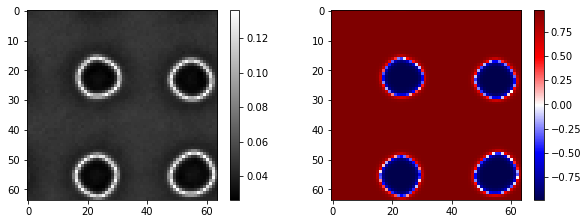

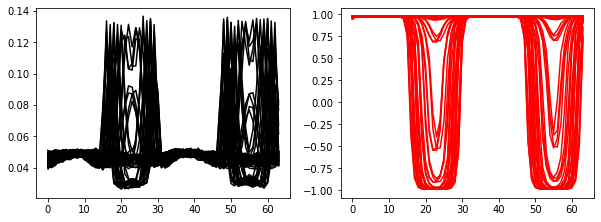

max_region_c: 0.13658682869580993 , max_region_s: 0.9793151650435649
min_region_c: 0.02629664015950256 , min_region_s: -0.985891280021364
amplitude_c: 0.055145094268153685 , amplitude_s: 0.9826032225324643
 
time_step= 3400
Tiempo CPU en segundos: 226.87
c.mean = 0.0498 s.mean = 0.7261
c.min  = 0.0262  s.min = -0.9856
c.max  = 0.1374  s.max = 0.9796


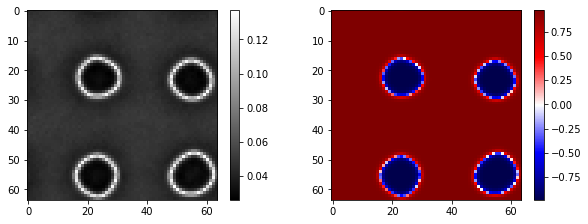

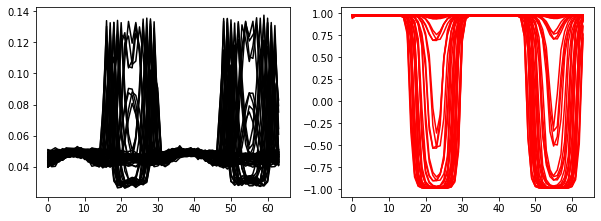

max_region_c: 0.1355664977801512 , max_region_s: 0.9794743993730064
min_region_c: 0.026216864432146086 , min_region_s: -0.9856461579535958
amplitude_c: 0.054674816674002556 , amplitude_s: 0.9825602786633011
 
time_step= 3500
Tiempo CPU en segundos: 234.08
c.mean = 0.0498 s.mean = 0.7278
c.min  = 0.0263  s.min = -0.9860
c.max  = 0.1370  s.max = 0.9797


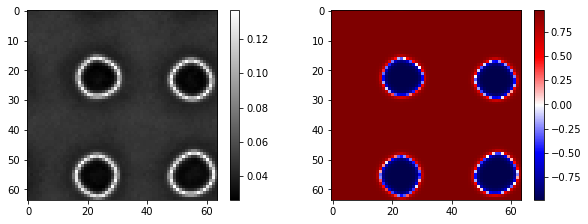

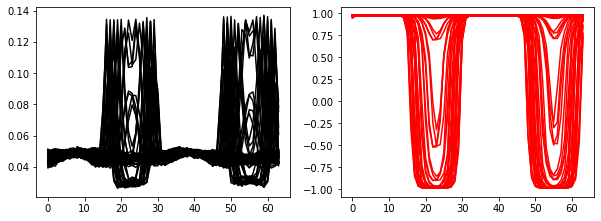

max_region_c: 0.13547922477624544 , max_region_s: 0.979325569101844
min_region_c: 0.026294832381060687 , min_region_s: -0.9859651029697489
amplitude_c: 0.054592196197592376 , amplitude_s: 0.9826453360357965
 
time_step= 3600
Tiempo CPU en segundos: 241.45
c.mean = 0.0498 s.mean = 0.7296
c.min  = 0.0260  s.min = -0.9863
c.max  = 0.1374  s.max = 0.9796


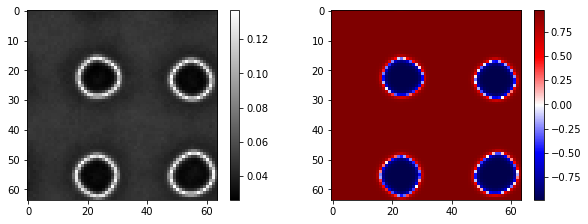

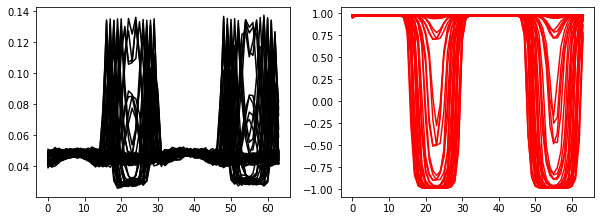

max_region_c: 0.13609769123142357 , max_region_s: 0.9793086701064077
min_region_c: 0.025998913403913478 , min_region_s: -0.9863219961889398
amplitude_c: 0.05504938891375505 , amplitude_s: 0.9828153331476737
 
time_step= 3700
Tiempo CPU en segundos: 248.76
c.mean = 0.0498 s.mean = 0.7315
c.min  = 0.0258  s.min = -0.9859
c.max  = 0.1380  s.max = 0.9797


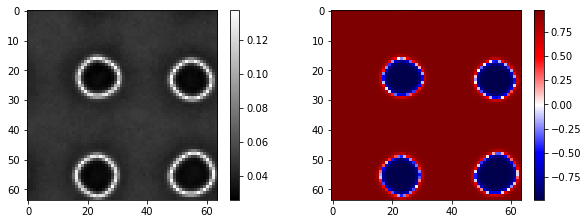

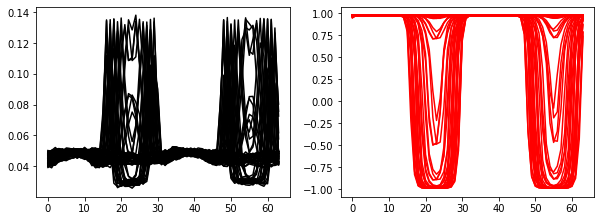

max_region_c: 0.13797632497498122 , max_region_s: 0.979507927320288
min_region_c: 0.025800481186093197 , min_region_s: -0.9858879793724776
amplitude_c: 0.05608792189444401 , amplitude_s: 0.9826979533463829
 
time_step= 3800
Tiempo CPU en segundos: 255.55
c.mean = 0.0498 s.mean = 0.7334
c.min  = 0.0253  s.min = -0.9863
c.max  = 0.1369  s.max = 0.9795


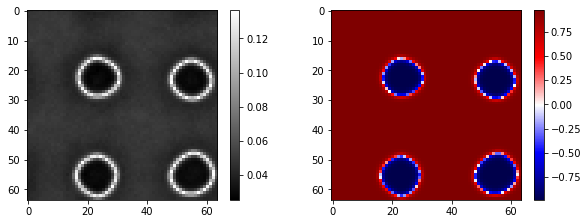

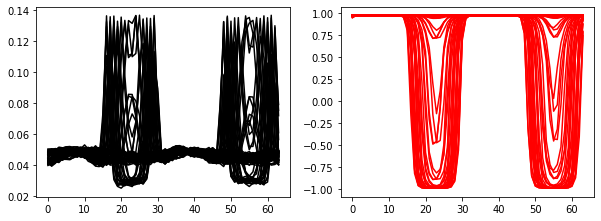

max_region_c: 0.1369430396360066 , max_region_s: 0.9793354995807312
min_region_c: 0.02530549967751928 , min_region_s: -0.9863114474438134
amplitude_c: 0.05581876997924366 , amplitude_s: 0.9828234735122723
 
time_step= 3900
Tiempo CPU en segundos: 262.07
c.mean = 0.0498 s.mean = 0.7355
c.min  = 0.0248  s.min = -0.9862
c.max  = 0.1377  s.max = 0.9800


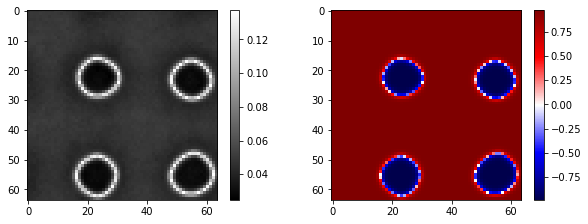

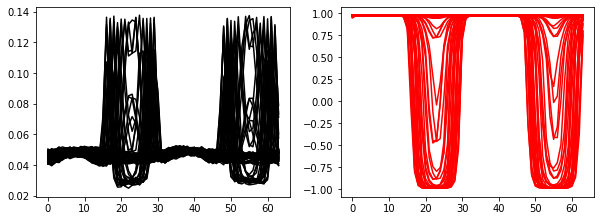

max_region_c: 0.13774157210523863 , max_region_s: 0.9798506717869637
min_region_c: 0.024804181824947924 , min_region_s: -0.9862467898995961
amplitude_c: 0.05646869514014535 , amplitude_s: 0.9830487308432799
 
time_step= 4000
Tiempo CPU en segundos: 268.31
c.mean = 0.0498 s.mean = 0.7376
c.min  = 0.0248  s.min = -0.9858
c.max  = 0.1385  s.max = 0.9798


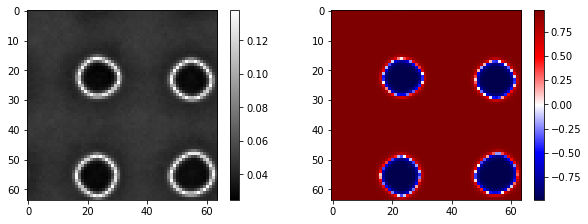

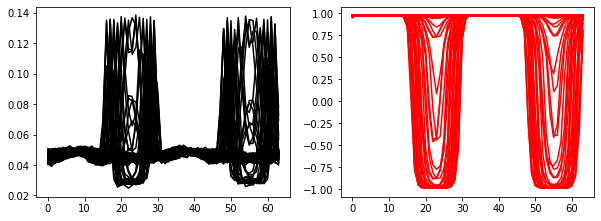

max_region_c: 0.13845217458683362 , max_region_s: 0.979767653722725
min_region_c: 0.024782904093545055 , min_region_s: -0.9858124642336712
amplitude_c: 0.05683463524664428 , amplitude_s: 0.9827900589781982
Program end.


In [76]:
print("Program will run nTimeSteps: ", nTimeSteps)
print("Print results each print_period steps: ", print_period)
print("Total simulation time at the end:", T_total)

print("Temperature: = {:.3f}" .format(T))
print("SW range lambda  = {:.3f}" .format(1+Lambda/10.0))
print("wavenumber k = {:.3f}" .format(k))
print("wavelength = {:.3f}" .format(lambd))

# Apply periodic boundary conditions to fields s & c
for x in (s,c):
    PBC(x)

# declare empty arrays vacíos 
time_step = []
amplitude_c_step = [] 
amplitude_s_step=[]

#define el tiempo inicial de corrida, será igual al tiempo real de comienzo
t0 = time.time()

# Save initial state
save_fields(s, c, 0, block)


# Solve the dynamics
for i in range(1,nTimeSteps+1):
   
    solve_dynamics(c,phi,Lambda,T,alphap,s,N,dx,dt,i,R,r)
        
    if( (i % print_period) == 0 ):
        print(" ")
        print("time_step=", i) 
        
        tf = time.time()
        print("Tiempo CPU en segundos: {:.2f}" .format(tf-t0))

            
        print("c.mean = {:.4f} s.mean = {:.4f}" .format(c.mean(), s.mean()))
        print("c.min  = {:.4f}  s.min = {:.4f}" .format(c.min(), s.min()))
        print("c.max  = {:.4f}  s.max = {:.4f}" .format(c.max(), s.max()))

        plot_fields_in_2D(s,c)
        plot_fields_in_1D(s, c)
        
        
#    Save to disk the pictures for the NP concentration and LC order parameter

#    plt.imshow(c, cmap=plt.cm.gray)
#    plt.colorbar()
#    plt.savefig('imagen{}.png'.format(i))
#    plt.show()


#    plt.imshow(s, cmap=plt.cm.seismic)
#    plt.colorbar()
#    plt.savefig('imagen{}.png'.format(i))
#    plt.show()
        
        
        # Measure the amplitude of the perturbations in c and s over time
        # Sample the central region  
        region_min = N//4         # Careful, // means integer division
        region_max = N//4 + N//2  # Again, // means integer division
    
        region_c = c[region_min:region_max]
        region_s=  s[region_min:region_max]
    
        # Obtain min and max for c and s in that region
        max_region_c= region_c.max()
        max_region_s= region_s.max()
        min_region_c= region_c.min()
        min_region_s= region_s.min()
    
        # Amplitude for each field equals half the range between the maximum and minimum values
        amplitude_c= (max_region_c-min_region_c)/2
        amplitude_s= (max_region_s-min_region_s)/2
    
        # Print out statistics 
        print("max_region_c:",max_region_c, ", max_region_s:",max_region_s )    
        print("min_region_c:",min_region_c, ", min_region_s:",min_region_s,)
        print("amplitude_c:",amplitude_c,   ", amplitude_s:",amplitude_s)

        # Collect amplitudes and corresponding time steps into arrays
        time_step.append(float(i))
        amplitude_c_step.append(amplitude_c)
        amplitude_s_step.append(amplitude_s)


print("Program end.")    
# End of main simulation program    

# Analysis of amplitude vs time

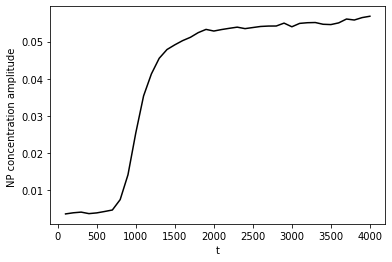

In [77]:
# Plot amplitude of NP concentration c vs time_step
plt.plot(time_step, amplitude_c_step, "k-")
plt.xlabel("t")
plt.ylabel("NP concentration amplitude ")
plt.show()

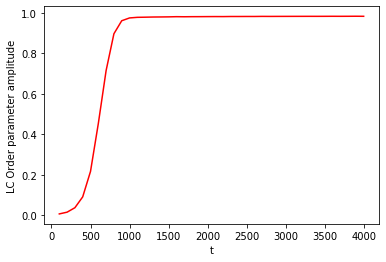

In [78]:
# Plot amplitude of LC order parameter s vs time_step
plt.plot(time_step, amplitude_s_step, "r-")
plt.xlabel("t")
plt.ylabel("LC Order parameter amplitude")
plt.show()

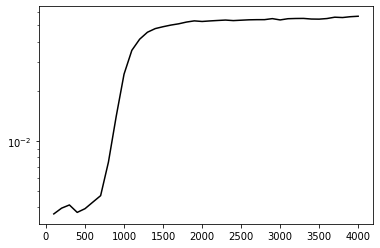

In [79]:
plt.semilogy(time_step, amplitude_c_step, "k-")

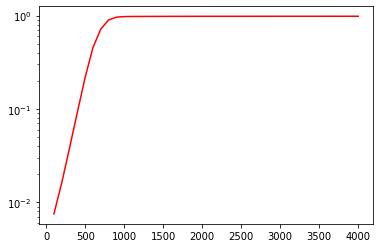

In [80]:
plt.semilogy(time_step, amplitude_s_step, "r-")